In [1]:
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from model import train_sia, train_sia_lgb
import shap
import utils
import scikitplot as skplt
import matplotlib.pyplot as plt
import warnings
from datalayer import read_sia_model
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
%matplotlib inline

/Users/helderrezende/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Stack:
    
    Modelo: Xgboost
    Validação: AUC
    Feature Importance: Shapley Values
    Train-test split: 0.8

O nosso principal objetivo foi ter um modelo que conseguisse reconhecer quando um paciente chega no estado avançado do câncer.

Para isso, tratamos os estados como:

- 0, 1, 2 -> 0
- 3, 4 -> 1

Ou seja, transformamos em um problema binário. Sendo 1 os casos graves, 0 não graves.


Utilizamos o xgboost por ser um modelo que tem uma perfomance boa em relação a dados tabulares.

### Radioterapia

Lendo os dados...

In [2]:
data_model = read_sia_model('../data/Linfomas Radioterapia SIA-SUS.csv', method='radioterapia')

Reading csv...
Transforming csv to train...


In [20]:
data_model = data_model[data_model['AP_CIDPRI'] == 'C81- Linfoma de Hodgkin']

In [23]:
data_model = data_model[data_model['AP_CIDPRI'] == 'C82-C85;C96- Linfoma não Hodgkin']

Para tratar os dados que na maioria dos datasets estavam desbalanceados, utilizamos a sugestão da documentação do XGBoost. https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html :

- Balance the positive and negative weights via scale_pos_weight

- Use AUC for evaluation

In [25]:
data_model.groupby('AR_ESTADI')['AP_MVM'].count()

AR_ESTADI
0.0     652
1.0     896
2.0    1182
3.0     884
4.0    1089
Name: AP_MVM, dtype: int64

Tivemos cuidado em selecionar quais features dos modelos para não ter vazamento de dados.

Como por exemplo, utilizar a idade para prever se está num estado grave.


Também não colocamos colunas sobre Longitude, Latitude, CEP ou dados em que ajudaria a prever o local.

In [26]:
%time model, X, X_with_cep, y_test, prob_preds, best_preds = train_sia(data_model)

training model...
ROC_AUC_SCORE: 57.87%
CPU times: user 2.88 s, sys: 18 ms, total: 2.9 s
Wall time: 2.93 s


In [27]:
%time model, X, X_with_cep, y_test, prob_preds, best_preds = train_sia_lgb(data_model)

training model...
ROC_AUC_SCORE: 60.22%
CPU times: user 2.27 s, sys: 33.1 ms, total: 2.3 s
Wall time: 385 ms


#### Roc Curves

In [28]:
proba = pd.DataFrame(prob_preds)
proba[0] = 1 - proba[0]
proba[1] = 1 - proba[0]

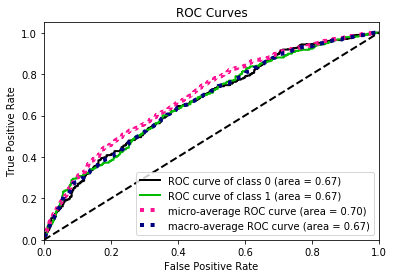

In [29]:
skplt.metrics.plot_roc_curve(y_test.values, proba)
plt.show()

#### Shapley Values - Relevance


Para calcular a importância das features do predict, utilizamos a biblioteca shap.

https://github.com/slundberg/shap

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods [1-7] and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see our papers for details and citations).

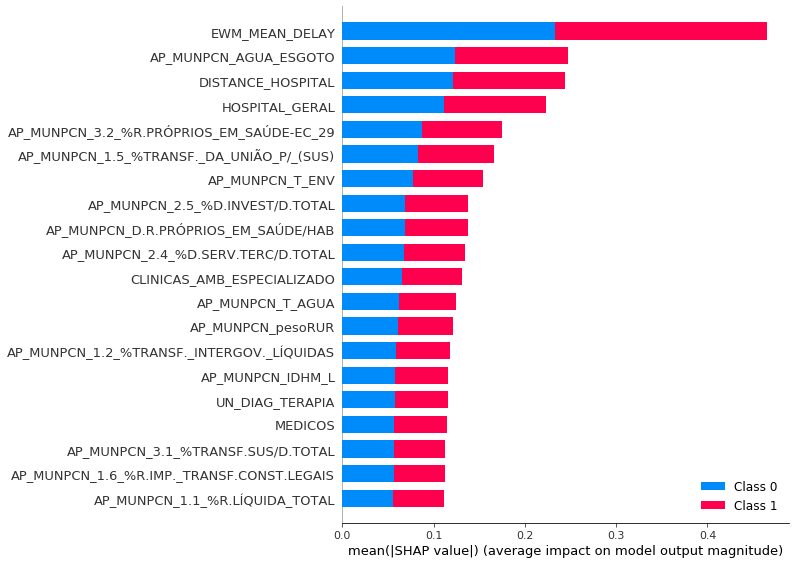

In [30]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")

Caso tenha dúvidas do signficado das colunas, tem um dicionário em notebook/Preprocessamento-SIA.ipynb

### Quimioterapia

In [11]:
data_model = read_sia_model('../data/Linfomas Quimioterapia SIA-SUS.csv', method='quimioterapia')

Reading csv...
Transforming csv to train...


In [3]:
data_model = data_model[data_model['AP_CIDPRI'] == 'C82-C85;C96- Linfoma não Hodgkin']

In [9]:
%time model, X, X_with_cep, y_test, prob_preds, best_preds = train_sia(data_model)

training model...
ROC_AUC_SCORE: 59.15%
CPU times: user 835 ms, sys: 6.18 ms, total: 841 ms
Wall time: 842 ms


In [10]:
%time model, X, X_with_cep, y_test, prob_preds, best_preds = train_sia_lgb(data_model)

training model...
ROC_AUC_SCORE: 60.01%
CPU times: user 1.84 s, sys: 23.3 ms, total: 1.86 s
Wall time: 332 ms


In [7]:
proba = pd.DataFrame(prob_preds)
proba[0] = 1 - proba[0]
proba[1] = 1 - proba[0]

#### Roc Curves

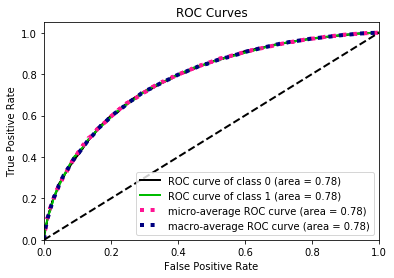

In [9]:
skplt.metrics.plot_roc_curve(y_test, proba)
plt.show()

#### Shapley Values - Relevance

##### Geral

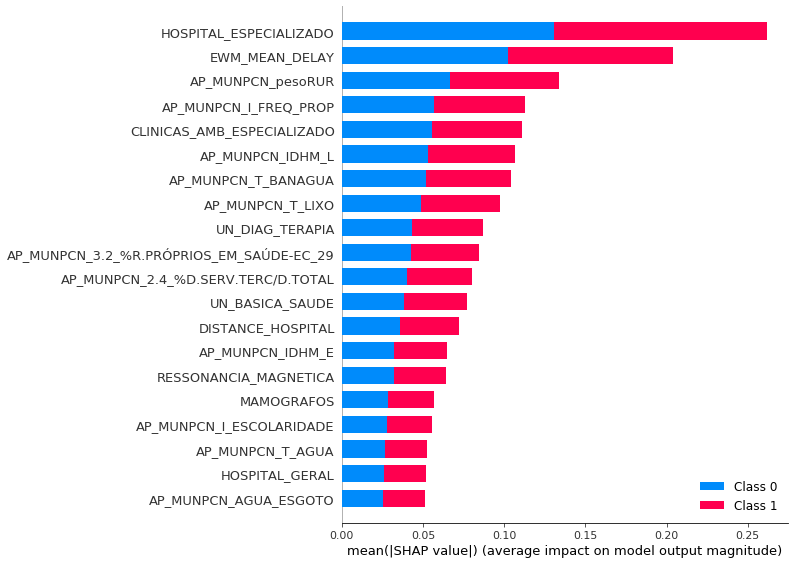

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")

Caso tenha dúvidas do signficado das colunas, tem um dicionário em notebook/Preprocessamento-SIA.ipynb

##### Análise por estado

Códigos: 

- 11	RO
- 12	AC
- 13	AM
- 14	RR
- 15	PA
- 16	AP
- 17	TO
- 21	MA
- 22	PI
- 23	CE
- 24	RN
- 25	PB
- 26	PE
- 27	AL
- 28	SE
- 29	BA
- 31	MG
- 32	ES
- 33	RJ
- 35	SP
- 41	PR
- 42	SC
- 43	RS
- 50	MS
- 51	MT
- 52	GO
- 53	DF

##### Rio de Janeiro

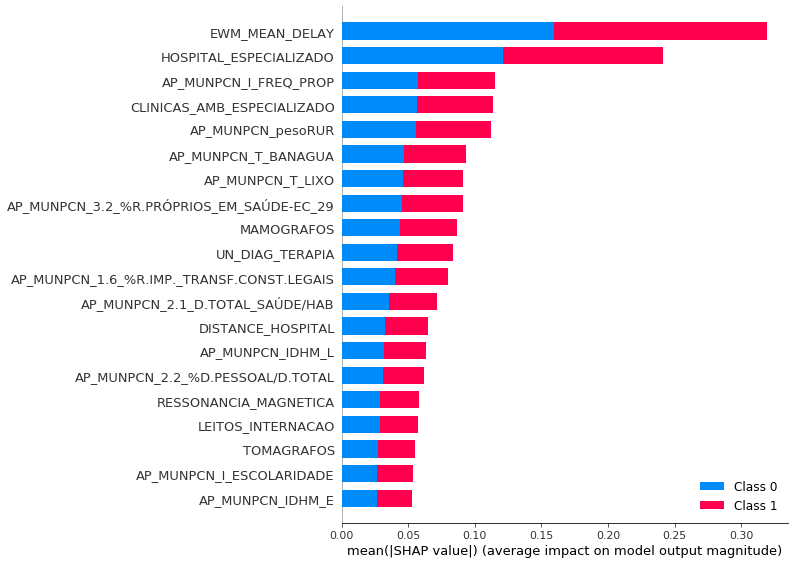

In [18]:
X_RJ = X_with_cep[(X_with_cep['AP_MUNPCN_CODIGO_UF'] == 33)].drop(['AP_MUNPCN_CODIGO_UF',
                                                                 'AP_CEPPCN', 'AP_MUNPCN_NOME', 'AP_MVM'], 1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_RJ)

shap.summary_plot(shap_values, X_RJ, plot_type="bar")

Caso tenha dúvidas do signficado das colunas, tem um dicionário em notebook/Preprocessamento-SIA.ipynb

##### Rio de Janeiro - Duque de Caxias

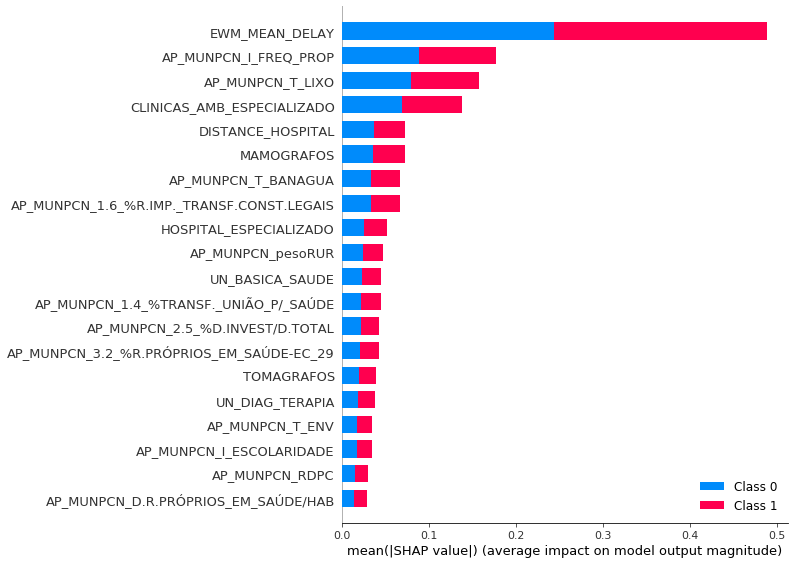

In [16]:
filter_loc = (X_with_cep['AP_MUNPCN_CODIGO_UF'] == 33) & (X_with_cep['AP_MUNPCN_NOME'] == 'Duque de Caxias') & \
                (X_with_cep['AP_MVM'] == '2018-12-01')

X_RJ = X_with_cep[filter_loc].drop(['AP_MUNPCN_CODIGO_UF','AP_CEPPCN', 'AP_MUNPCN_NOME', 'AP_MVM'], 1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_RJ)

shap.summary_plot(shap_values, X_RJ, plot_type="bar")

In [17]:
X_RJ

,CLINICAS_AMB_ESPECIALIZADO,HOSPITAL_ESPECIALIZADO,HOSPITAL_GERAL,UN_BASICA_SAUDE,UN_DIAG_TERAPIA,LEITOS_INTERNACAO,MAMOGRAFOS,RAIO_X,TOMAGRAFOS,RESSONANCIA_MAGNETICA,AP_MUNPCN_GINI,AP_MUNPCN_RDPC,AP_MUNPCN_T_AGUA,AP_MUNPCN_AGUA_ESGOTO,AP_MUNPCN_T_BANAGUA,AP_MUNPCN_T_LIXO,AP_MUNPCN_I_ESCOLARIDADE,AP_MUNPCN_I_FREQ_PROP,AP_MUNPCN_IDHM,AP_MUNPCN_IDHM_E,AP_MUNPCN_IDHM_L,EWM_MEAN_DELAY,AP_MUNPCN_IDHM_R,MEDICOS,ENFERMEIROS,DISTANCE_HOSPITAL,AP_MUNPCN_1.1_%R.LÍQUIDA_TOTAL,AP_MUNPCN_1.2_%TRANSF._INTERGOV._LÍQUIDAS,AP_MUNPCN_1.3_%TRANSF._PARA_A_SAÚDE_(SUS),AP_MUNPCN_1.4_%TRANSF._UNIÃO_P/_SAÚDE,AP_MUNPCN_1.5_%TRANSF._DA_UNIÃO_P/_(SUS),AP_MUNPCN_1.6_%R.IMP._TRANSF.CONST.LEGAIS,AP_MUNPCN_2.1_D.TOTAL_SAÚDE/HAB,AP_MUNPCN_2.2_%D.PESSOAL/D.TOTAL,AP_MUNPCN_2.3_%D.COM_MEDICAMENTOS,AP_MUNPCN_2.4_%D.SERV.TERC/D.TOTAL,AP_MUNPCN_2.5_%D.INVEST/D.TOTAL,AP_MUNPCN_3.1_%TRANSF.SUS/D.TOTAL,AP_MUNPCN_3.2_%R.PRÓPRIOS_EM_SAÚDE-EC_29,AP_MUNPCN_R.TRANSF.SUS/HAB,AP_MUNPCN_D.R.PRÓPRIOS_EM_SAÚDE/HAB,AP_MUNPCN_pesoRUR,AP_MUNPCN_T_ENV
14876,0.002319,0.000076,0.000132,0.000340,0.000680,0.010308,0.000030,0.000468,0.000055,0.000027,0.46,592.81,94.78,3.23,88.87,95.44,0.584,0.645,0.711,0.624,0.833,80.257969,0.692,0.023974,0.014240,17.72,19.70,76.59,16.93,99.81,61.24,62.02,690.83,36.68,0.0,44.50,1.79,51.24,18.03,353.98,304.01,0.003266,6.61
14890,0.002303,0.000077,0.000145,0.000338,0.000670,0.010310,0.000030,0.000467,0.000054,0.000027,0.46,592.81,94.78,3.23,88.87,95.44,0.584,0.645,0.711,0.624,0.833,52.250462,0.692,0.024555,0.015205,26.28,19.70,76.59,16.93,99.81,61.24,62.02,690.83,36.68,0.0,44.50,1.79,51.24,18.03,353.98,304.01,0.003266,6.61
14895,0.002354,0.000076,0.000134,0.000347,0.000678,0.010015,0.000029,0.000467,0.000054,0.000027,0.46,592.81,94.78,3.23,88.87,95.44,0.584,0.645,0.711,0.624,0.833,56.450963,0.692,0.024260,0.014749,34.90,19.70,76.59,16.93,99.81,61.24,62.02,690.83,36.68,0.0,44.50,1.79,51.24,18.03,353.98,304.01,0.003266,6.61
62766,0.002103,0.000072,0.000140,0.000322,0.000640,0.010495,0.000030,0.000467,0.000051,0.000025,0.46,592.81,94.78,3.23,88.87,95.44,0.584,0.645,0.711,0.624,0.833,100.051787,0.692,0.024460,0.014369,19.82,21.95,73.10,14.70,96.05,54.26,64.19,603.48,39.03,0.0,44.49,5.11,40.58,21.62,244.88,315.85,0.003266,6.61
62780,0.001702,0.000087,0.000133,0.000265,0.000587,0.012410,0.000031,0.000427,0.000049,0.000020,0.46,592.81,94.78,3.23,88.87,95.44,0.584,0.645,0.711,0.624,0.833,287.409851,0.692,0.022561,0.012509,29.86,26.30,66.78,16.38,97.17,57.13,70.02,660.75,35.89,4.4,40.67,3.25,35.06,26.73,231.66,395.89,0.003297,6.61
62790,0.002079,0.000077,0.000140,0.000318,0.000622,0.010538,0.000030,0.000471,0.000051,0.000025,0.46,592.81,94.78,3.23,88.87,95.44,0.584,0.645,0.711,0.624,0.833,154.681118,0.692,0.024826,0.014581,20.09,21.95,73.10,14.70,96.05,54.26,64.19,603.48,39.03,0.0,44.49,5.11,40.58,21.62,244.88,315.85,0.003266,6.61


Caso tenha dúvidas do signficado das colunas, tem um dicionário em notebook/Preprocessamento-SIA.ipynb

##### Parana

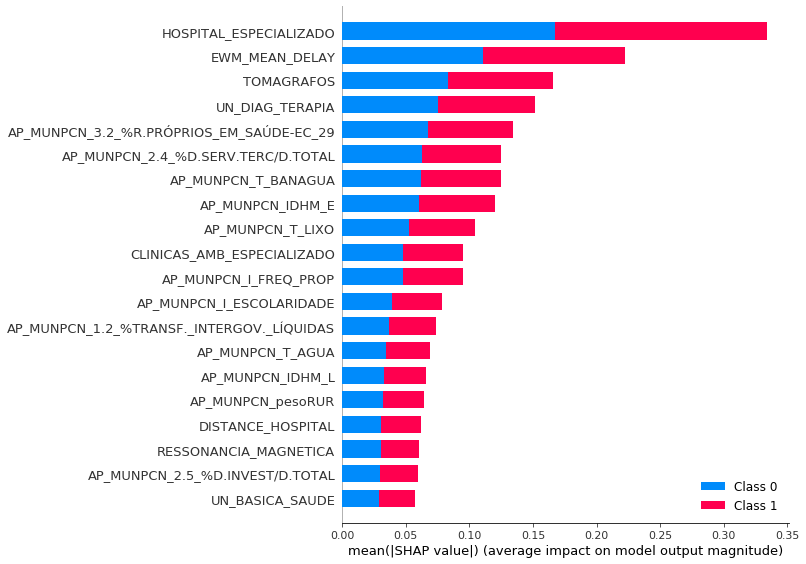

In [12]:
X_PR = X_with_cep[X_with_cep['AP_MUNPCN_CODIGO_UF'] == 41].drop(['AP_MUNPCN_CODIGO_UF',
                                                                 'AP_CEPPCN', 'AP_MUNPCN_NOME', 'AP_MVM'], 1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_PR)

shap.summary_plot(shap_values, X_PR, plot_type="bar")

In [16]:
X_PR = X_with_cep[X_with_cep['AP_MUNPCN_CODIGO_UF'] == 41].drop(['AP_MUNPCN_CODIGO_UF',
                                                                 'AP_CEPPCN', 'AP_MUNPCN_NOME'], 1)

Caso tenha dúvidas do signficado das colunas, tem um dicionário em notebook/Preprocessamento-SIA.ipynb

##### Rondonia

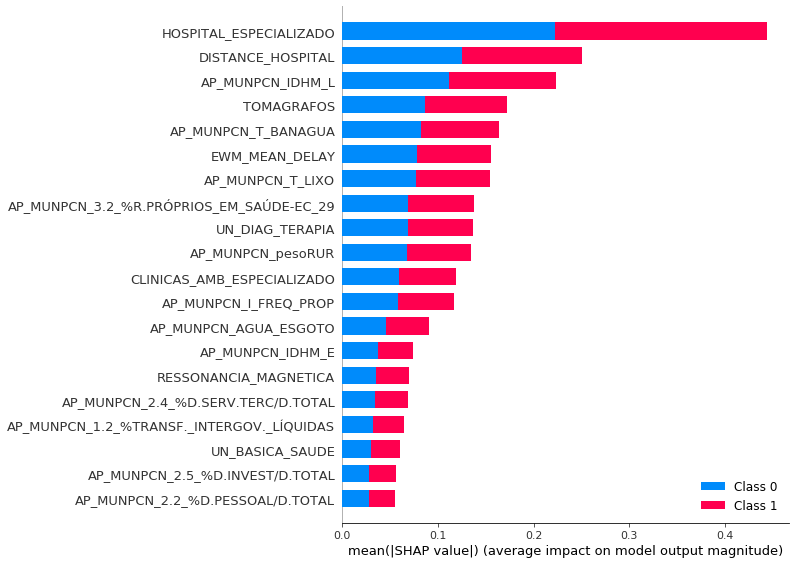

In [13]:
X_RO = X_with_cep[X_with_cep['AP_MUNPCN_CODIGO_UF'] == 11].drop(['AP_MUNPCN_CODIGO_UF',
                                                                 'AP_CEPPCN', 'AP_MUNPCN_NOME', 'AP_MVM'], 1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_RO)

shap.summary_plot(shap_values, X_RO, plot_type="bar")

Caso tenha dúvidas do signficado das colunas, tem um dicionário em notebook/Preprocessamento-SIA.ipynb

##### Pernambuco

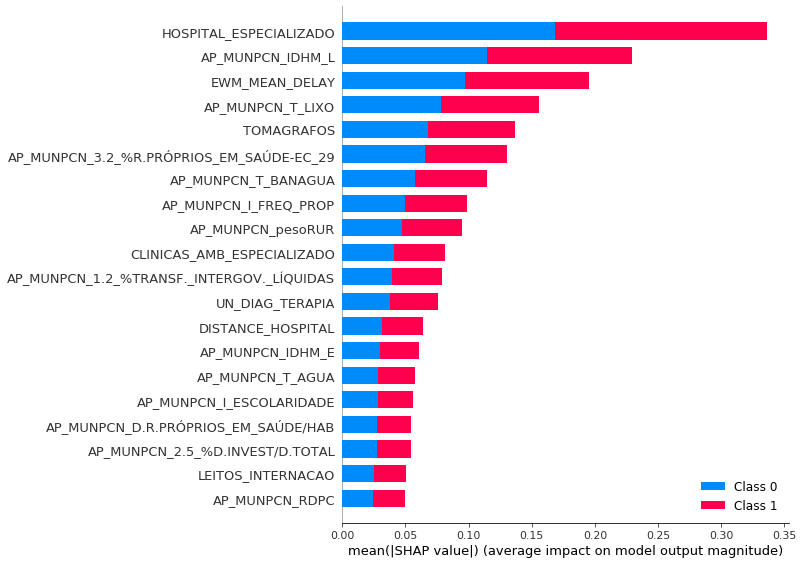

In [14]:
X_PE = X_with_cep[X_with_cep['AP_MUNPCN_CODIGO_UF'] == 26].drop(['AP_MUNPCN_CODIGO_UF',
                                                                 'AP_CEPPCN', 'AP_MUNPCN_NOME', 'AP_MVM'], 1)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_PE)

shap.summary_plot(shap_values, X_PE, plot_type="bar")

Caso tenha dúvidas do signficado das colunas, tem um dicionário em notebook/Preprocessamento-SIA.ipynb

##### Mato Grosso do Sul

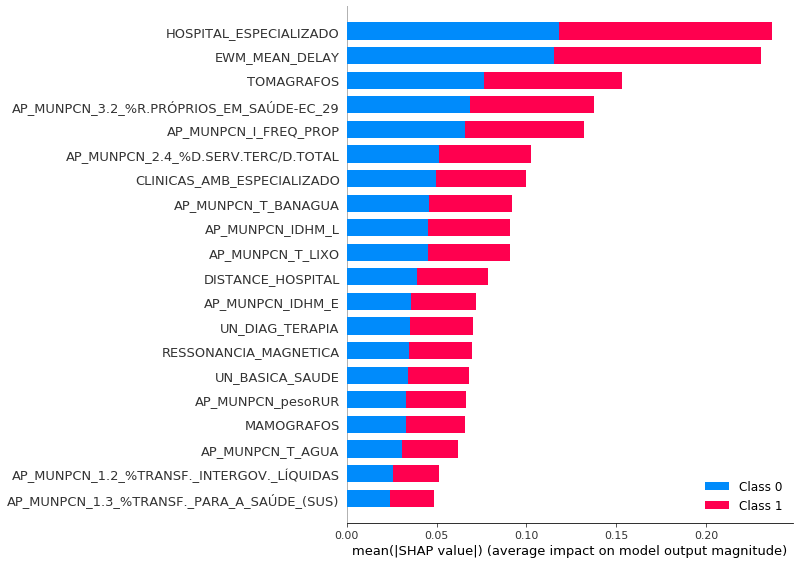

In [15]:
X_MS = X_with_cep[X_with_cep['AP_MUNPCN_CODIGO_UF'] == 50].drop(['AP_MUNPCN_CODIGO_UF',
                                                                 'AP_CEPPCN', 'AP_MUNPCN_NOME', 'AP_MVM'], 1)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_MS)

shap.summary_plot(shap_values, X_MS, plot_type="bar")

Caso tenha dúvidas do signficado das colunas, tem um dicionário em notebook/Preprocessamento-SIA.ipynb

### Radioterapia + Quimioterapia

In [7]:
radioterapia = read_sia_model('../data/Linfomas Radioterapia SIA-SUS.csv', method='radioterapia')
quimioterapia = read_sia_model('../data/Linfomas Quimioterapia SIA-SUS.csv', method='quimioterapia')

Reading csv...
Transforming csv to train...
Reading csv...
Transforming csv to train...


In [11]:
total = pd.concat([radioterapia, quimioterapia])

In [13]:
model, X, X_with_cep, y_test, prob_preds, best_preds = train_sia(total)

training model...
ROC_AUC_SCORE: 63.90%


#### Roc Curves

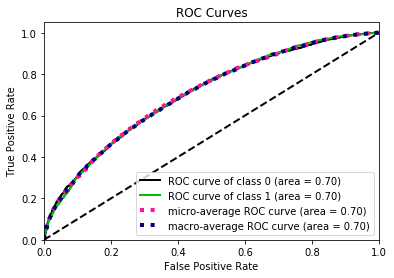

In [15]:
skplt.metrics.plot_roc_curve(y_test, prob_preds)
plt.show()

#### Shapley Values - Relevance

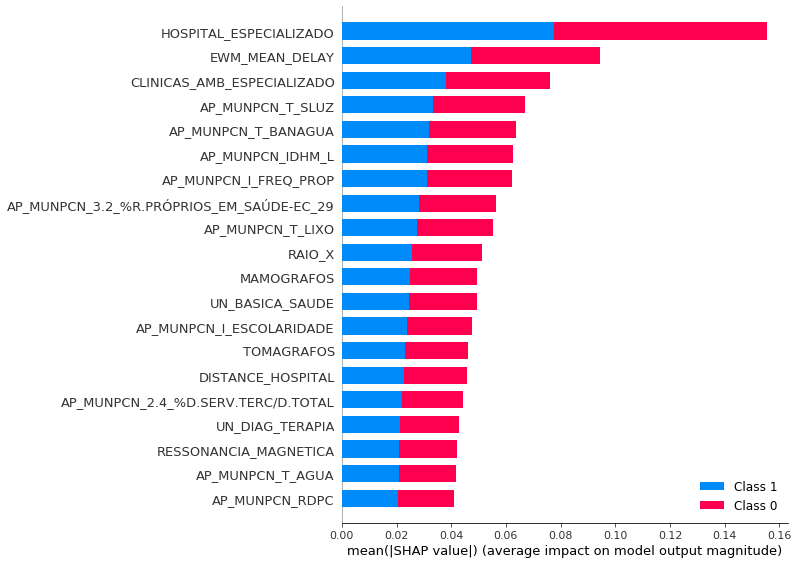

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")